In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.ensemble import RandomForestClassifier
from math import sqrt
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#take the dataframe and only present the relevant category
def filter_aggregate_sales(frame, column_to_filter, column_value_to_filter, column_to_aggregate):
    frame = frame[frame[column_to_filter] == column_value_to_filter]
    frame = frame.groupby(column_to_aggregate).sum().T
    return frame

In [3]:
#ETSmodel prediction feature
def ETS_predict(frame, column_to_predict, days_to_predict):
    modelETS = ETSModel(frame.set_index('date')[column_to_predict].iloc[:-days_to_predict]/100, error="add", trend="add", seasonal="add",
                damped_trend=False, seasonal_periods=7)
    fit = modelETS.fit()
    prediction = fit.predict(start= frame.date.min(), end= frame.date.max())
    frame = frame.assign(ETS=prediction.values*100).set_index('date')
    return frame

In [4]:
#Create training/test dataset
def train_test_set(frame, target_feature, start_date, end_date):
    splittedframe = frame[start_date:end_date]
    input_train = splittedframe.drop(target_feature, axis='columns')
    target_train = splittedframe[target_feature]
    return input_train, target_train 

In [5]:
#Model and predict data using Random Forest 
def forest(X_train, y_train, X_test):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_test)
    return y_predicted 

In [6]:
#Function to create train/test split and do model and prediction
def split_n_model(frame, target_feature, train_start_date, train_end_date,
                 test_start_date, test_end_date):
    
    X_train, y_train = train_test_set(frame=frame, target_feature = target_feature,
                                      start_date=train_start_date, end_date=train_end_date)
    
    X_test, y_test   = train_test_set(frame=frame, target_feature = target_feature,
                                      start_date=test_start_date, end_date=test_end_date)
    
    y_predicted      = forest(X_train, y_train, X_test)
    
    return y_test, y_predicted

### Fitting each category individually (without hierarchy):

In [7]:
#Cal_features is the features taken from 003-EK-model from cleanmergedframe
sales = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
cal_features = pd.read_csv('/Users/user/hts-forecast/volume/data/processed/sales_cal_features.csv')
cal_features.drop('Unnamed: 0', axis='columns', inplace=True)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [8]:
food = filter_aggregate_sales(frame=sales, column_to_filter='cat_id',
                                    column_value_to_filter='FOODS', column_to_aggregate='cat_id')

list_of_foods = ['FOODS_1', 'FOODS_2', 'FOODS_3']

for foods in list_of_foods:
    food[foods] = filter_aggregate_sales(frame=sales, column_to_filter='dept_id',
                                    column_value_to_filter=foods, column_to_aggregate='dept_id')[foods]
    

food

cat_id,FOODS,FOODS_1,FOODS_2,FOODS_3
d_1,23178,2343,4094,16741
d_2,22758,2216,4209,16333
d_3,17174,1657,3174,12343
d_4,18878,1508,3606,13764
d_5,14603,1209,2869,10525
...,...,...,...,...
d_1937,24790,3073,4648,17069
d_1938,24737,3251,4551,16935
d_1939,28136,3735,4815,19586
d_1940,33599,4195,5940,23464


In [9]:
#Create features for foods category and sub categories
foods_sales = cal_features.copy()
foods_sales['FOODS'] = food['FOODS'].values
foods_sales['ETS'] = ETS_predict(frame=foods_sales, column_to_predict='FOODS', days_to_predict=120)['ETS'].values
foods_sales.date = pd.to_datetime(foods_sales.date)
foods_sales.set_index('date', inplace=True)

foods_1_sales = cal_features.copy()
foods_1_sales['FOODS_1'] = food['FOODS_1'].values
foods_1_sales['ETS'] = ETS_predict(frame=foods_1_sales, column_to_predict='FOODS_1', days_to_predict=120)['ETS'].values
foods_1_sales.date = pd.to_datetime(foods_1_sales.date)
foods_1_sales.set_index('date', inplace=True)

foods_2_sales = cal_features.copy()
foods_2_sales['FOODS_2'] = food['FOODS_2'].values
foods_2_sales['ETS'] = ETS_predict(frame=foods_2_sales, column_to_predict='FOODS_2', days_to_predict=120)['ETS'].values
foods_2_sales.date = pd.to_datetime(foods_2_sales.date)
foods_2_sales.set_index('date', inplace=True)

foods_3_sales = cal_features.copy()
foods_3_sales['FOODS_3'] = food['FOODS_3'].values
foods_3_sales['ETS'] = ETS_predict(frame=foods_3_sales, column_to_predict='FOODS_3', days_to_predict=120)['ETS'].values
foods_3_sales.date = pd.to_datetime(foods_3_sales.date)
foods_3_sales.set_index('date', inplace=True)


In [23]:
foods_3_sales

,wday,month,event_type_1,week_of_year,FOODS_3,ETS
date,,,,,,
2011-01-29,1,1,0,4,16741,14360.207831
2011-01-30,2,1,0,4,16333,15197.741548
2011-01-31,3,1,0,5,12343,12000.992396
2011-02-01,4,2,0,5,13764,11521.478058
2011-02-02,5,2,0,5,10525,11963.640047
...,...,...,...,...,...,...
2016-05-18,5,5,0,20,17069,15367.524582
2016-05-19,6,5,0,20,16935,15521.681264
2016-05-20,7,5,0,20,19586,16354.892664


In [10]:
foods_y_test, foods_y_predicted = split_n_model(frame=foods_sales, target_feature='FOODS',
                                                train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                test_start_date='2016-01-24', test_end_date='2016-05-22')

foods_1_y_test, foods_1_y_predicted = split_n_model(frame=foods_1_sales, target_feature='FOODS_1',
                                                    train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                    test_start_date='2016-01-24', test_end_date='2016-05-22')

foods_2_y_test, foods_2_y_predicted = split_n_model(frame=foods_2_sales, target_feature='FOODS_2',
                                                    train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                  test_start_date='2016-01-24', test_end_date='2016-05-22')

foods_3_y_test, foods_3_y_predicted = split_n_model(frame=foods_3_sales, target_feature='FOODS_3',
                                                    train_start_date='2011-01-29', train_end_date='2016-01-22', 
                                                  test_start_date='2016-01-24', test_end_date='2016-05-22')


FOODS:
Average sales for foods items is:  28314.183333333334
Root mean squared error is:  4165.983047253073
Residual mean is:  3088.95


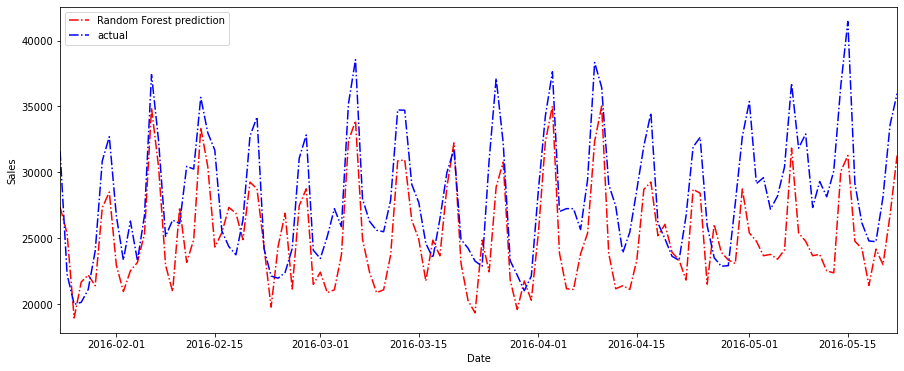

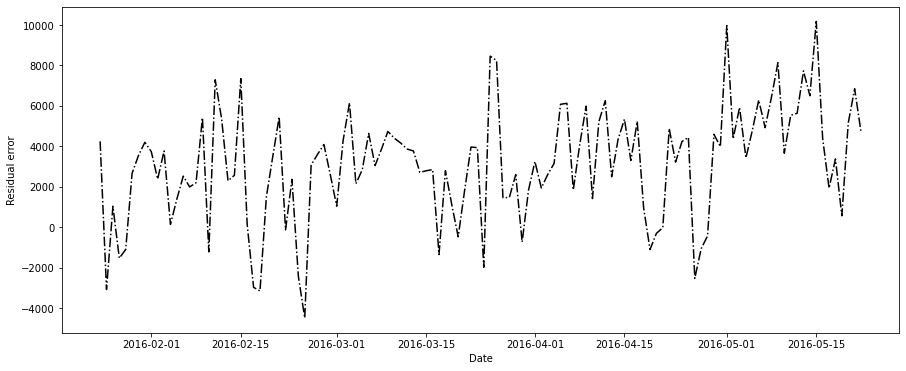

FOODS_1:
Average sales for foods(1) items is:  3216.4416666666666
Root mean squared error is:  915.1696472967913
Residual mean is:  -220.08333333333334


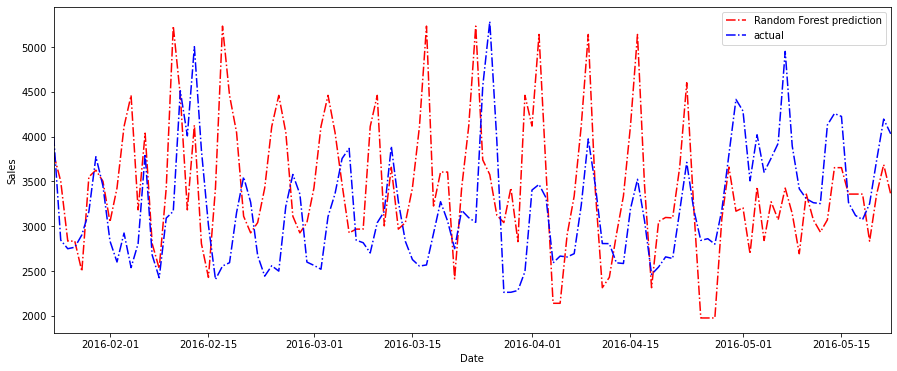

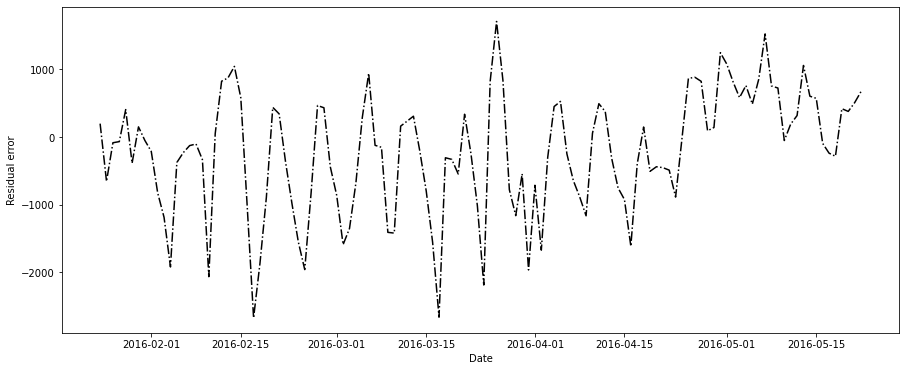

FOODS_2:
Average sales for foods(2) items is:  5733.533333333334
Root mean squared error is:  1322.0911812982743
Residual mean is:  993.925


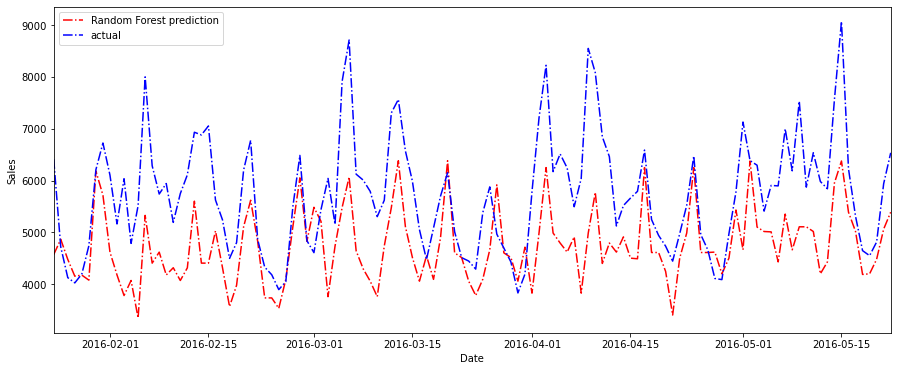

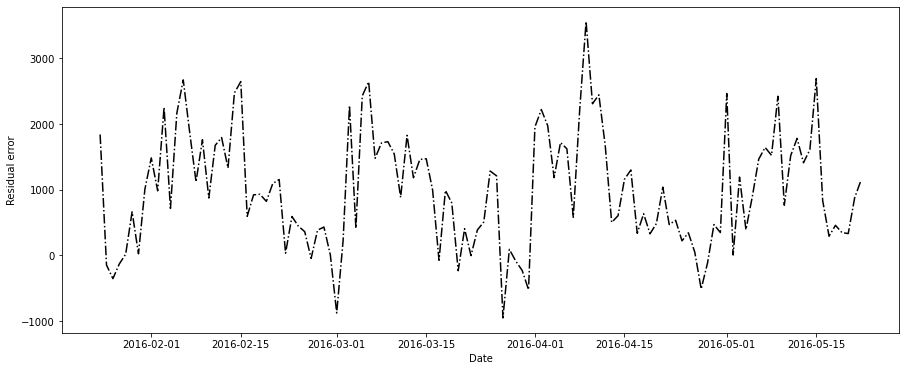

FOODS_3:
Average sales for foods(3) items is:  19364.208333333332
Root mean squared error is:  2649.23114318098
Residual mean is:  2060.733333333333


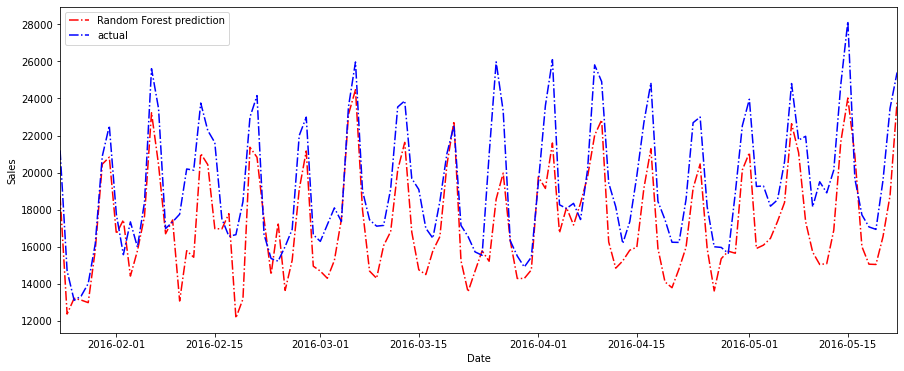

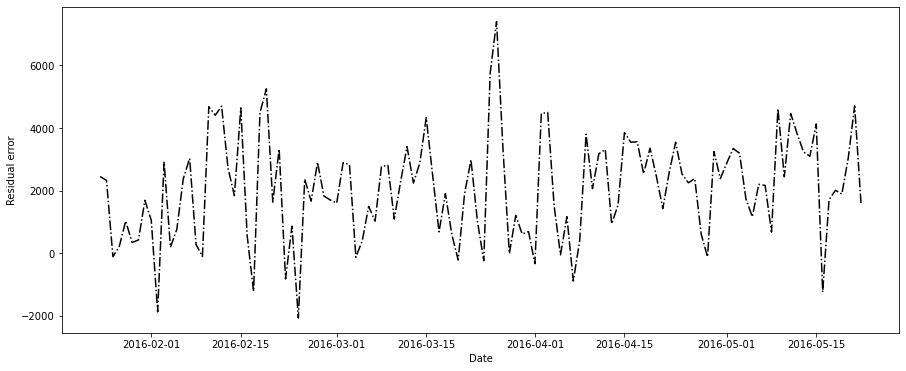

In [11]:
print("FOODS:")
print("Average sales for foods items is: ", foods_y_test.mean())
rmse = sqrt(mean_squared_error(foods_y_test, foods_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_y_test.index, foods_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_y_test-foods_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_1:")
print("Average sales for foods(1) items is: ", foods_1_y_test.mean())
rmse = sqrt(mean_squared_error(foods_1_y_test, foods_1_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_1_y_test.index, foods_1_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_1_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_1_y_test-foods_1_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_2:")
print("Average sales for foods(2) items is: ", foods_2_y_test.mean())
rmse = sqrt(mean_squared_error(foods_2_y_test, foods_2_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_2_y_test.index, foods_2_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_2_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_2_y_test-foods_2_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_3:")
print("Average sales for foods(3) items is: ", foods_3_y_test.mean())
rmse = sqrt(mean_squared_error(foods_3_y_test, foods_3_y_predicted))
print("Root mean squared error is: ", rmse)
    
plt.figure(figsize=(15,6))
plt.plot(foods_3_y_test.index, foods_3_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_3_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_3_y_test-foods_3_y_predicted
print("Residual mean is: ", y_residual.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()


### Lets compare these with using FOODS prediction to predict the sub-categories by doing weighted top-down:

In [12]:
foods3_fraction = foods_3_sales.FOODS_3.sum()/foods_sales.FOODS.sum()
foods3_fraction

0.717231299643636

In [13]:
foods_3_sales.FOODS_3

date
2011-01-29    16741
2011-01-30    16333
2011-01-31    12343
2011-02-01    13764
2011-02-02    10525
              ...  
2016-05-18    17069
2016-05-19    16935
2016-05-20    19586
2016-05-21    23464
2016-05-22    25401
Name: FOODS_3, Length: 1941, dtype: int64

In [14]:
foods2_fraction = foods_2_sales.FOODS_2.sum()/foods_sales.FOODS.sum()
foods2_fraction

0.1697433151780066

In [15]:
foods1_fraction = foods_1_sales.FOODS_1.sum()/foods_sales.FOODS.sum()
foods1_fraction

0.1130253851783574

In [16]:
foods_sales.FOODS

date
2011-01-29    23178
2011-01-30    22758
2011-01-31    17174
2011-02-01    18878
2011-02-02    14603
              ...  
2016-05-18    24790
2016-05-19    24737
2016-05-20    28136
2016-05-21    33599
2016-05-22    35967
Name: FOODS, Length: 1941, dtype: int64

FOODS_1:
Average sales for foods(1) items is:  3216.4416666666666
Root mean squared error is:  915.1696472967913
(top down) Root mean squared error is:  659.3932960232668
Residual mean is:  -220.08333333333334
(top down) Residual mean is:  365.34995295272614


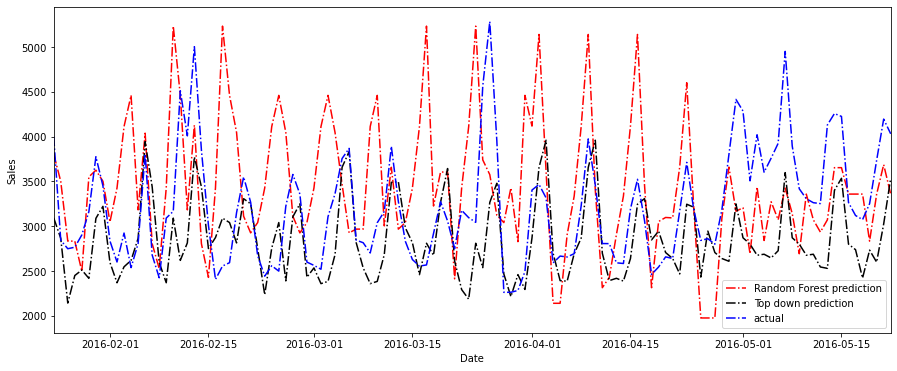

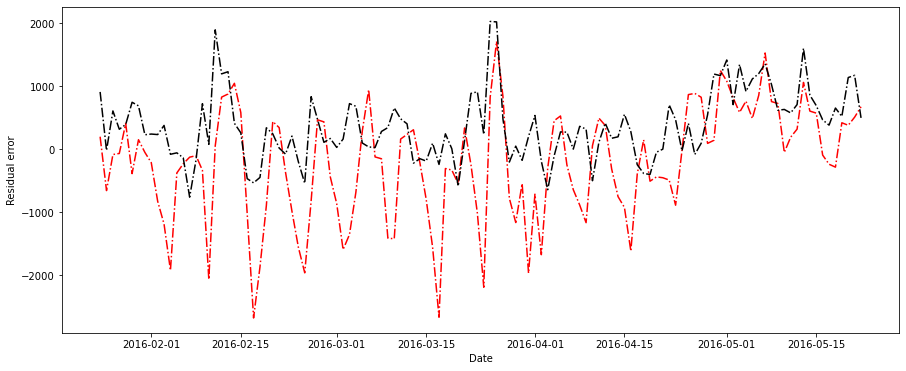

FOODS_2:
Average sales for foods(2) items is:  5733.533333333334
Root mean squared error is:  1322.0911812982743
(top down) Root mean squared error is:  1667.7699917653276
Residual mean is:  993.925
(top down) Residual mean is:  1451.7186011945757


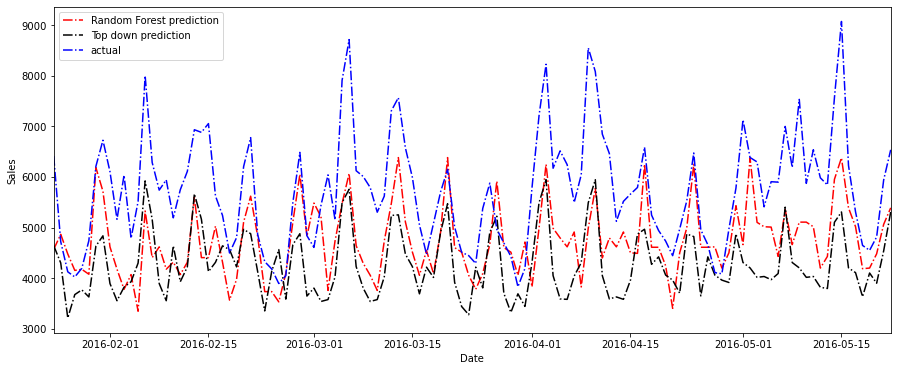

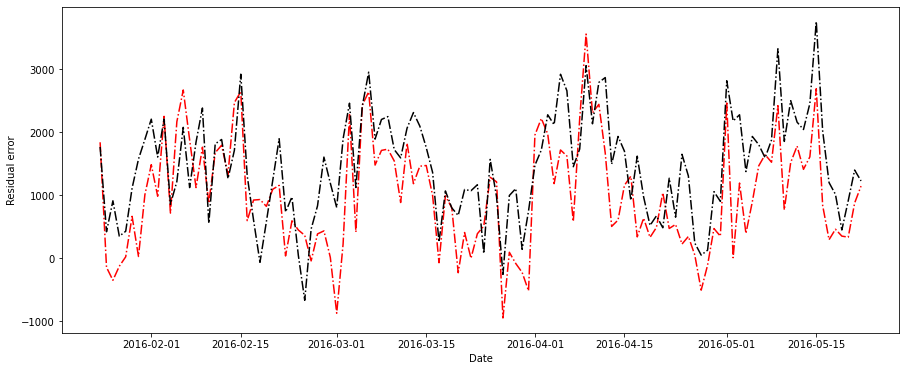

FOODS_3:
Average sales for foods(3) items is:  19364.208333333332
Root mean squared error is:  2649.23114318098
(top down) Root mean squared error is:  2242.42318432613
Residual mean is:  2060.733333333333
(top down) Residual mean is:  1271.8814458527


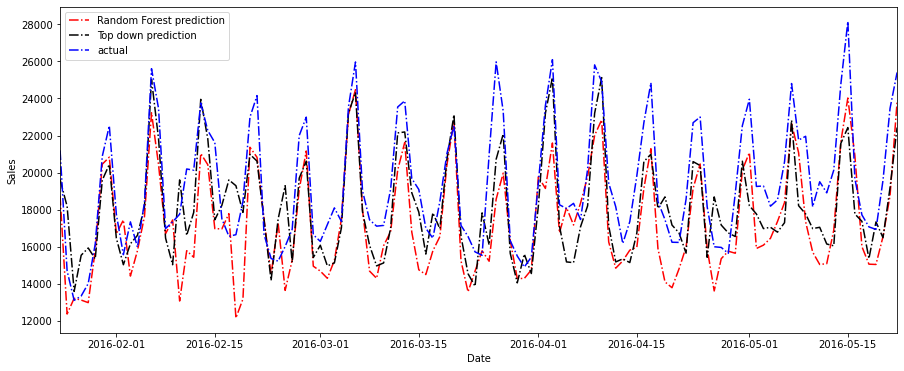

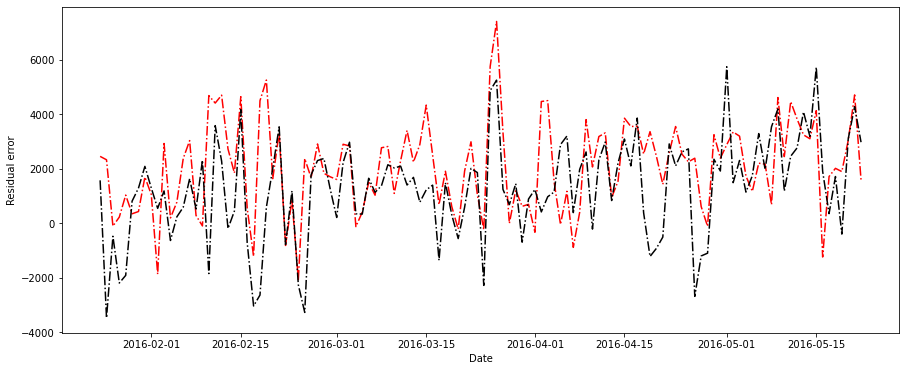

In [17]:
#Plot Foods sub categories direct predictions vs top down predictions 

print("FOODS_1:")
print("Average sales for foods(1) items is: ", foods_1_y_test.mean())
rmse = sqrt(mean_squared_error(foods_1_y_test, foods_1_y_predicted))
print("Root mean squared error is: ", rmse)
rmse2 = sqrt(mean_squared_error(foods_1_y_test, foods_y_predicted*(foods1_fraction)))
print("(top down) Root mean squared error is: ", rmse2)
    
plt.figure(figsize=(15,6))
plt.plot(foods_1_y_test.index, foods_1_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_1_y_test.index, foods_y_predicted*(foods1_fraction),'k-.' , label='Top down prediction')
plt.plot(foods_1_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_1_y_test-foods_1_y_predicted
print("Residual mean is: ", y_residual.mean())
y_residual2 = foods_1_y_test-(foods_y_predicted*(foods1_fraction))
print("(top down) Residual mean is: ", y_residual2.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'r-.')
plt.plot(y_residual2,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_2:")
print("Average sales for foods(2) items is: ", foods_2_y_test.mean())
rmse = sqrt(mean_squared_error(foods_2_y_test, foods_2_y_predicted))
print("Root mean squared error is: ", rmse)
rmse2 = sqrt(mean_squared_error(foods_2_y_test, foods_y_predicted*(foods2_fraction)))
print("(top down) Root mean squared error is: ", rmse2)
    
plt.figure(figsize=(15,6))
plt.plot(foods_2_y_test.index, foods_2_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_2_y_test.index, foods_y_predicted*(foods2_fraction),'k-.' , label='Top down prediction')
plt.plot(foods_2_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_2_y_test-foods_2_y_predicted
print("Residual mean is: ", y_residual.mean())
y_residual2 = foods_2_y_test-(foods_y_predicted*(foods2_fraction))
print("(top down) Residual mean is: ", y_residual2.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'r-.')
plt.plot(y_residual2,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

print("FOODS_3:")
print("Average sales for foods(3) items is: ", foods_3_y_test.mean())
rmse = sqrt(mean_squared_error(foods_3_y_test, foods_3_y_predicted))
print("Root mean squared error is: ", rmse)
rmse2 = sqrt(mean_squared_error(foods_3_y_test, foods_y_predicted*(foods3_fraction)))
print("(top down) Root mean squared error is: ", rmse2)
    
plt.figure(figsize=(15,6))
plt.plot(foods_3_y_test.index, foods_3_y_predicted,'r-.' , label='Random Forest prediction')
plt.plot(foods_3_y_test.index, foods_y_predicted*(foods3_fraction),'k-.' , label='Top down prediction')
plt.plot(foods_3_y_test,'b-.', label='actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xlim('2016-01-24', '2016-05-22')
plt.legend()
#Residual
y_residual = foods_3_y_test-foods_3_y_predicted
print("Residual mean is: ", y_residual.mean())
y_residual2 = foods_3_y_test-(foods_y_predicted*(foods3_fraction))
print("(top down) Residual mean is: ", y_residual2.mean())
plt.figure(figsize=(15,6))
plt.plot(y_residual,'r-.')
plt.plot(y_residual2,'k-.')
plt.xlabel('Date')
plt.ylabel('Residual error')
plt.show()

### Lets try for food (granular) items individually

In [18]:
sales[sales.cat_id == 'FOODS'].item_id

1612     FOODS_1_001
1613     FOODS_1_002
1614     FOODS_1_003
1615     FOODS_1_004
1616     FOODS_1_005
            ...     
30485    FOODS_3_823
30486    FOODS_3_824
30487    FOODS_3_825
30488    FOODS_3_826
30489    FOODS_3_827
Name: item_id, Length: 14370, dtype: object

In [19]:
foods_items = pd.DataFrame()
for items in sales[sales.cat_id == 'FOODS'].item_id:
    foods_items[items] = filter_aggregate_sales(frame=sales, column_to_filter='item_id',
                                    column_value_to_filter=items, column_to_aggregate='item_id')[items]

    
foods_items

,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
d_1,6,4,14,0,34,16,0,0,0,7,...,0,56,18,0,34,15,6,6,0,0
d_2,6,5,8,0,32,9,0,0,0,1,...,0,41,13,0,31,9,4,15,0,0
d_3,4,7,3,0,13,20,0,0,0,5,...,0,25,13,0,25,9,7,4,0,0
d_4,6,4,6,0,20,16,0,0,0,1,...,0,17,12,0,27,14,9,13,0,0
d_5,7,3,3,0,10,14,0,0,0,0,...,0,25,5,0,12,4,6,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
d_1937,7,5,7,62,25,13,3,2,2,3,...,30,22,17,7,13,12,4,12,13,14
d_1938,5,0,7,71,19,9,2,7,4,8,...,15,9,16,8,21,13,9,17,9,24
d_1939,7,6,10,75,25,9,1,10,9,5,...,24,21,20,17,27,15,10,15,13,37
d_1940,5,6,6,83,17,11,0,10,6,16,...,24,12,20,7,30,14,1,9,17,38


In [20]:
#test to see if the sales fractions are reasonable 
for cols in foods_items: 
    print(foods_items[cols].sum()/foods_sales.FOODS.sum())

0.0002701076752759605
0.00016255673943365407
0.00029567252619292097
0.0028798782782103395
0.0005099686913324507
0.0004927657678022985
8.749537562550865e-05
0.0001616203777731521
0.00013585954418306333
0.0002264035391683458
0.0018865074356806098
0.000539975816173653
0.00030174798905989876
0.0002775550168548365
0.0003025972473101215
0.00016871930571091113
0.002967874498444954
0.0014229648620270004
0.00037471887102134214
0.0006096367685444848
6.709140176759386e-05
0.0006786444453382222
0.00046883410582807396
0.00020693592697093295
0.00021205325232483903
0.0008106278877638588
0.0003179492233718396
0.0001021505244049928
0.00016961211566627346
0.00044069970430787555
0.00278428228542886
5.831573318195922e-05
0.000141368834883226
0.00020090401580909477
0.0005603144624738584
0.0003942082590713248
0.0002679954175766886
0.00010302155850778531
0.0005745994217596557
0.00032511347886730814
0.001028604171987687
0.0028792032267806753
0.0006232249005480482
0.0006262952957603918
0.0027841298544608716
0.

0.0001698080983394018
5.3133080270343724e-05
0.00039126851897440003
0.0003702765970971003
0.0009870776211370535
0.000514476292814402
0.00021873843906377162
0.0007863478121485173
7.209984785865086e-05
8.451208382344426e-05
0.0003499815025020346
0.00011155769271515201
0.004085149942096919
0.000623246676400618
6.961740066569217e-05
0.00020504142779735924
0.0005207041866493685
0.0004200126443665532
0.0003095001925747522
0.0005806313329214939
0.0005306121995686334
9.239494245371657e-05
6.595905743396359e-05
8.72558412472407e-05
0.00029584673301347945
0.0013074439641441425
0.0006565855066850017
4.5642186986328054e-05
0.0005573747223769336
0.00048179073810711265
0.00027404910459109664
0.0005770383172474747
0.0002647072638386469
0.0004148735431600773
0.0005399322644685134
0.0039751165590616545
0.000259916576273288
0.00043061748456805213
8.581863497763304e-05
0.0003882634513197658
0.0004451419782321174
8.353217045780267e-05
0.0008433134424711481
5.657366497637418e-05
0.0011908778253379335
0.000

0.00039529705169981546
0.00012967520205323644
0.00045459269824741624
0.0019991539210242526
0.00015404238107885718
0.0008144604378161459
0.0005355117663968414
0.0003781812315799424
0.00021967480072427356
0.0006501180784717672
0.0005968978947911442
0.00021745366376215263
0.005577536222116483
0.0013187020799227357
0.0004791776357987351
0.00031912511941060957
0.00043636630964648276
0.00019591734557060757
0.00037145249313587017
0.001939923602034361
0.0003625679452873865
5.417832119369475e-05
5.454851068738157e-05
0.0011568421677713157
4.122168891465601e-05
0.00862186573893405
0.0016569899495947808
4.836416855755468e-05
0.0021878199076891124
0.0003342811127991994
0.0002507489423413967
0.00016116308486918604
0.002772240238957754
0.00012381749771195674
0.001609453263434879
0.00032409001379652693
0.0005260174946764029
0.00034675867632170227
0.000504002107728322
0.00015295358845036653
0.00010859617676565744
0.0042115369904121135
0.0003930759147376945
6.319352415759733e-05
0.008756309852700076
0.

In [21]:
#take first ten foods items as examples as test the top down approach 
ten_foods_items = foods_items.iloc[:, :10]
ten_foods_items.head()

,FOODS_1_001,FOODS_1_002,FOODS_1_003,FOODS_1_004,FOODS_1_005,FOODS_1_006,FOODS_1_008,FOODS_1_009,FOODS_1_010,FOODS_1_011
d_1,6,4,14,0,34,16,0,0,0,7
d_2,6,5,8,0,32,9,0,0,0,1
d_3,4,7,3,0,13,20,0,0,0,5
d_4,6,4,6,0,20,16,0,0,0,1
d_5,7,3,3,0,10,14,0,0,0,0


FOODS_1_001
Average sales for  FOODS_1_001  is:  5.725
 Root mean squared error is:  5.041457292846413
(top down) Residual mean is:  -2.4875955803020964
The fraction of sales with respect to FOODS is:  0.0023897965474722564


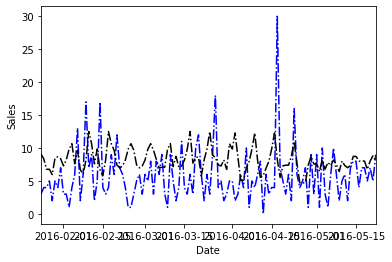

FOODS_1_002
Average sales for  FOODS_1_002  is:  4.158333333333333
 Root mean squared error is:  2.5526820752701096
(top down) Residual mean is:  -0.7841873057310934
The fraction of sales with respect to FOODS is:  0.001438232120838471


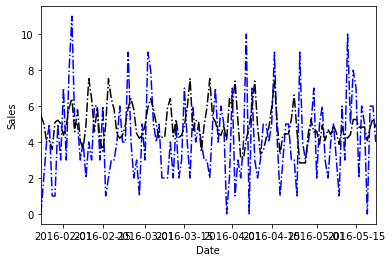

FOODS_1_003
Average sales for  FOODS_1_003  is:  5.833333333333333
 Root mean squared error is:  4.746744320256272
(top down) Residual mean is:  -3.1565588618731995
The fraction of sales with respect to FOODS is:  0.0026159833538840936


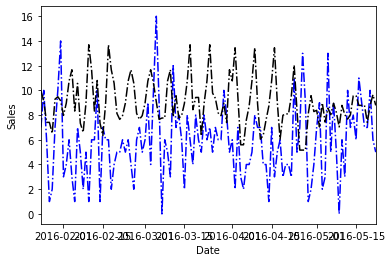

FOODS_1_004
Average sales for  FOODS_1_004  is:  31.4
 Root mean squared error is:  77.65367829345175
(top down) Residual mean is:  -56.16239745973335
The fraction of sales with respect to FOODS is:  0.02547992447595561


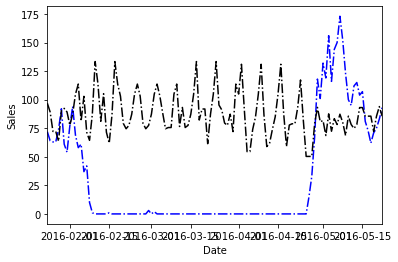

FOODS_1_005
Average sales for  FOODS_1_005  is:  19.425
 Root mean squared error is:  9.232858865703871
(top down) Residual mean is:  3.9194553454454364
The fraction of sales with respect to FOODS is:  0.0045119836621455


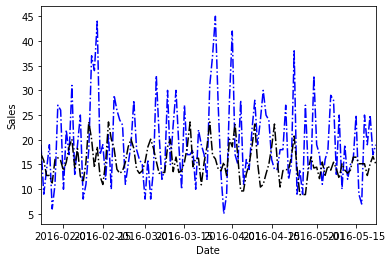

FOODS_1_006
Average sales for  FOODS_1_006  is:  11.675
 Root mean squared error is:  8.20768713783557
(top down) Residual mean is:  -3.3074915661606052
The fraction of sales with respect to FOODS is:  0.004359779593094945


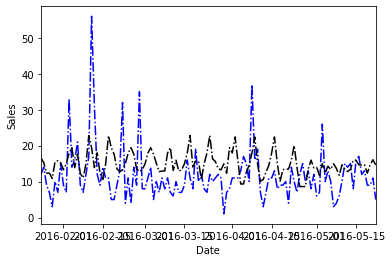

FOODS_1_008
Average sales for  FOODS_1_008  is:  2.308333333333333
 Root mean squared error is:  2.131713429313923
(top down) Residual mean is:  -0.3519543997893545
The fraction of sales with respect to FOODS is:  0.0007741214549938347


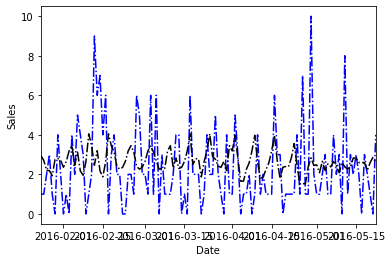

FOODS_1_009
Average sales for  FOODS_1_009  is:  3.2416666666666667
 Root mean squared error is:  5.759571419337248
(top down) Residual mean is:  -1.6723839941687229
The fraction of sales with respect to FOODS is:  0.0014299475955610358


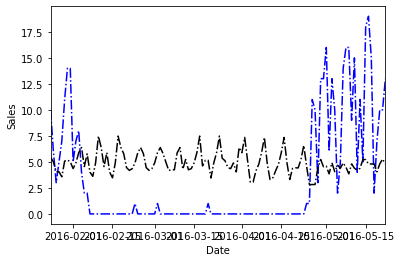

FOODS_1_010
Average sales for  FOODS_1_010  is:  5.608333333333333
 Root mean squared error is:  3.9339849534790283
(top down) Residual mean is:  1.477538120054974
The fraction of sales with respect to FOODS is:  0.0012020268187422935


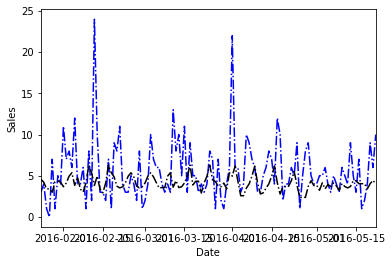

FOODS_1_011
Average sales for  FOODS_1_011  is:  9.758333333333333
 Root mean squared error is:  5.39292360368226
(top down) Residual mean is:  2.874557434558672
The fraction of sales with respect to FOODS is:  0.0020031211467324292


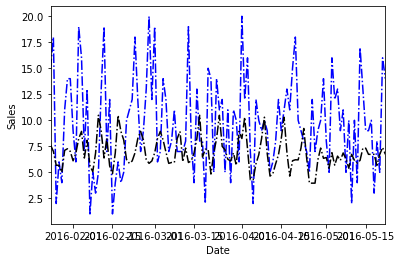

In [22]:
#test the top down approach using FOODS and scaling down by using the weighted sum of sales for the items
for col in ten_foods_items:
    print(col)
    print("Average sales for ", col, " is: ", ten_foods_items[col][-120:].mean())
    rmse = sqrt(mean_squared_error(ten_foods_items[col][-120:],
                                   foods_1_y_predicted*(foods_items[col].sum()/foods_1_sales.FOODS_1.sum())))
    print(" Root mean squared error is: ", rmse)
    
    y_residual2 = ten_foods_items[col][-120:]-foods_1_y_predicted*(foods_items[col].sum()/foods_1_sales.FOODS_1.sum())
    print("(top down) Residual mean is: ", y_residual2.mean())
    
    print("The fraction of sales with respect to FOODS is: ", (foods_items[col].sum()/foods_1_sales.FOODS_1.sum()))
    
    plt.plot(foods_3_y_test.index, ten_foods_items[col][-120:],'b-.', label='actual')
    plt.plot(foods_3_y_test.index, foods_1_y_predicted*(foods_items[col].sum()/foods_1_sales.FOODS_1.sum()),'k-.' , label='Top down prediction')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xlim('2016-01-24', '2016-05-22')
    plt.show()
   
